In [44]:
# Importing key libraries 
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults 
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,d,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse,mse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Import Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [46]:
# Load datasets
df = pd.read_excel('GDP.xlsx',index_col='Year',parse_dates=True)

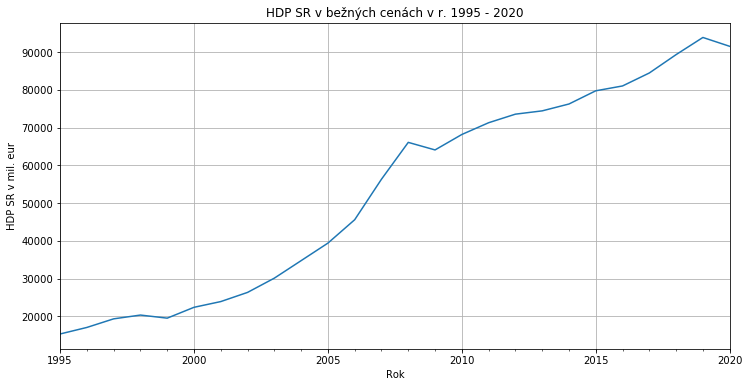

In [68]:
title = 'HDP SR v bežných cenách v r. 1995 - 2020'
xlabel = 'Rok'
ylabel = 'HDP SR v mil. eur'

ax = df['GDP'].plot(figsize=(12,6),title=title,grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

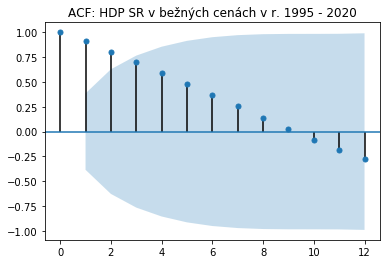

In [48]:
title = 'ACF: HDP SR v bežných cenách v r. 1995 - 2020'
lags = 12
plot_acf(df['GDP'],title=title,lags=lags);

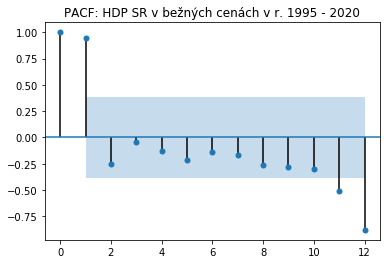

In [49]:
title = 'PACF: HDP SR v bežných cenách v r. 1995 - 2020'
lags = 12
plot_pacf(df['GDP'],title=title,lags=lags);

In [50]:
adf_test(df['GDP'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.230316
p-value                  0.934810
# lags used              0.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


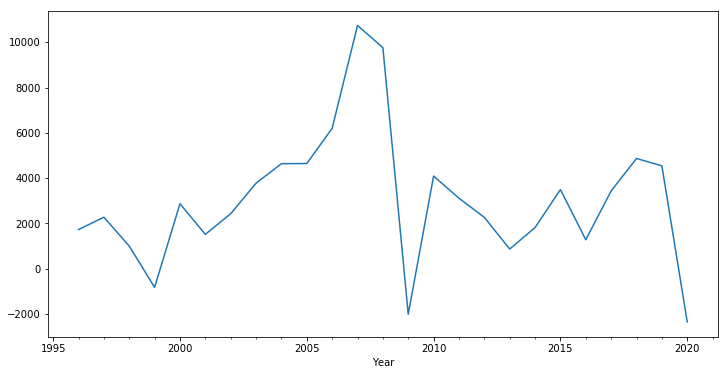

In [51]:
#Differencing data due to non stationarity - 1st difference
df['d1'] = diff(df['GDP'],k_diff=1)
df['d1'].plot(figsize=(12,6));

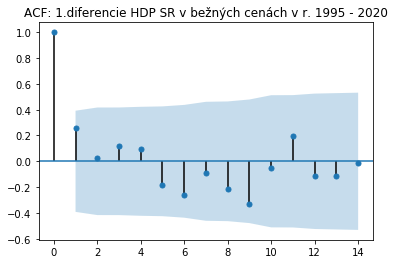

In [52]:
#ACF plot for 1st difference
title='ACF: 1.diferencie HDP SR v bežných cenách v r. 1995 - 2020'
lags=15
plot_acf(df['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

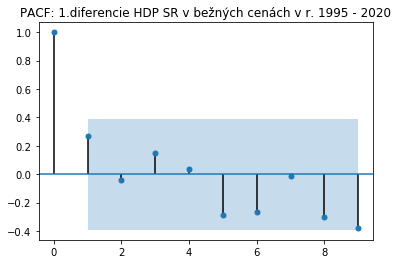

In [53]:
#PACF plot for 1st difference
title='PACF: 1.diferencie HDP SR v bežných cenách v r. 1995 - 2020'
lags=10
plot_pacf(df['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

In [54]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.199174
p-value                  0.020033
# lags used              0.000000
# observations          24.000000
critical value (1%)     -3.737709
critical value (5%)     -2.992216
critical value (10%)    -2.635747
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [67]:
#Running auto_arima function which measures many different models, do the differencing on its own

stepwise_fit = auto_arima(df['GDP'], start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=476.046, BIC=480.921, Fit time=0.129 seconds
Fit ARIMA: order=(0, 1, 0); AIC=474.181, BIC=476.619, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=474.273, BIC=477.929, Fit time=0.083 seconds
Fit ARIMA: order=(0, 1, 1); AIC=474.050, BIC=477.706, Fit time=0.048 seconds
Fit ARIMA: order=(0, 1, 2); AIC=476.047, BIC=480.922, Fit time=0.120 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.400 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   25
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -234.025
Method:                       css-mle   S.D. of innovations           2806.781
Date:                Sun, 06 Mar 2022   AIC                            474.050
Time:                        18:57:27   BIC                            477.706
Sample:                             1   HQIC                           475.064
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2961.0728    739.750      4.003      0.001    1511.189    4410.957
ma.L1.D.y      0.3270      0.208      1.572      0.130      -0.081       0.735
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.0581           +0.0000j            3.0581            0.5000
-----------------------------------------------------------------------------
"""

In [56]:
# Splitting into train and test period
train = df.iloc[:20]
test = df.iloc[20:]

In [100]:
#Checking the best model after splitting
model = ARIMA(train['GDP'],order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.GDP   No. Observations:                   19
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -178.234
Method:                       css-mle   S.D. of innovations           2859.619
Date:                Mon, 07 Mar 2022   AIC                            362.467
Time:                        20:47:40   BIC                            365.300
Sample:                    01-01-1996   HQIC                           362.947
                         - 01-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3173.6545    870.659      3.645      0.002    1467.195    4880.114
ma.L1.D.GDP     0.3449      0.208      1.660      0.115      -0.062       0.752
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.8996           +0.0000j            2.8996            0.5000
-----------------------------------------------------------------------------
"""

In [101]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,1) Test predictions')

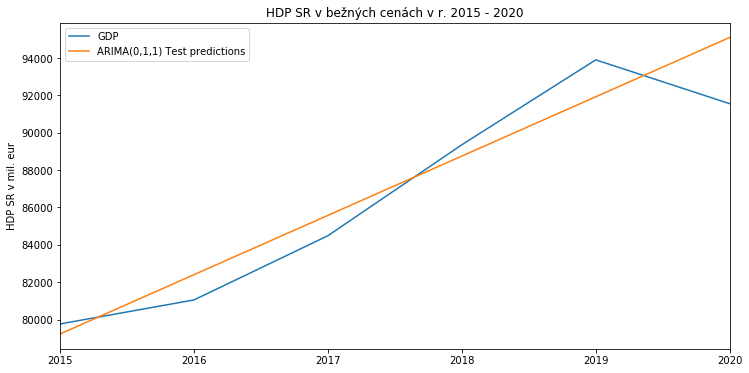

In [102]:
#Plotting predictions vs. expected data
title = 'HDP SR v bežných cenách v r. 2015 - 2020'
ylabel='HDP SR v mil. eur'
xlabel='' # we don't really need a label here

ax = test['GDP'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [103]:
# predicted vs. expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['GDP'][i]}")

predicted=79230.08639, expected=79767.6
predicted=82403.74086, expected=81051.5
predicted=85577.39533, expected=84488.6
predicted=88751.04979, expected=89356.7
predicted=91924.70426, expected=93900.5
predicted=95098.35873, expected=91555.3


In [104]:
#MSE and RMSE calculation
error = mse(test['GDP'], predictions)
print(f'ARIMA(0,1,1) MSE Error: {error:11.10}')
error = rmse(test['GDP'], predictions)
print(f'ARIMA(0,1,1) RMSE Error: {error:11.10}')

ARIMA(0,1,1) MSE Error:  3354466.27
ARIMA(0,1,1) RMSE Error: 1831.520207


In [105]:
#Retraining the model on full dataset
model = ARIMA(df['GDP'],order=(0,1,1))
results = model.fit()
forecast = results.predict(len(df),len(df)+9,typ='levels').rename('ARIMA(0,1,1) Forecast')

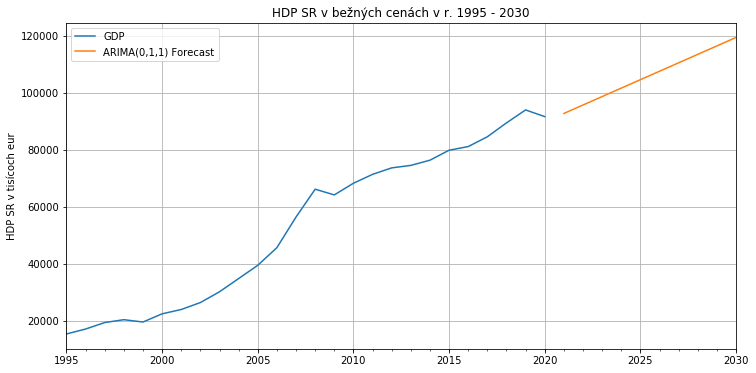

In [106]:
# Plot predictions against known values
title = 'HDP SR v bežných cenách v r. 1995 - 2030'
ylabel='HDP SR v tisícoch eur'
xlabel='' # we don't really need a label here

ax = df['GDP'].plot(legend=True,figsize=(12,6),title=title,grid=True)
forecast.plot(legend=True,grid=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [107]:
forecast

2021-01-01     92666.090206
2022-01-01     95627.163013
2023-01-01     98588.235819
2024-01-01    101549.308626
2025-01-01    104510.381432
2026-01-01    107471.454239
2027-01-01    110432.527045
2028-01-01    113393.599852
2029-01-01    116354.672658
2030-01-01    119315.745465
Freq: AS-JAN, Name: ARIMA(0,1,1) Forecast, dtype: float64

In [31]:
title = 'Zlogaritmovaný HDP SR v bežných cenách v r. 1995 - 2020'
xlabel = 'Rok'
ylabel = 'HDP SR v tisícoch eur'

ax = df['lnGDP'].plot(figsize=(12,6),title=title,grid=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True)

KeyError: 'lnGDP'

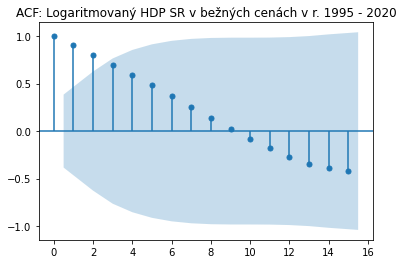

In [41]:
title = 'ACF: Logaritmovaný HDP SR v bežných cenách v r. 1995 - 2020'
lags = 15
plot_acf(df['GDP'],title=title,lags=lags);

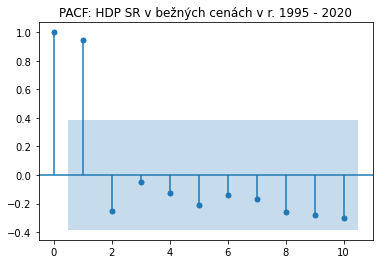

In [42]:
title = 'PACF: HDP SR v bežných cenách v r. 1995 - 2020'
lags = 10
plot_pacf(df['GDP'],title=title,lags=lags);

In [43]:
adf_test(df['lnGDP'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.203157
p-value                  0.205102
# lags used              0.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


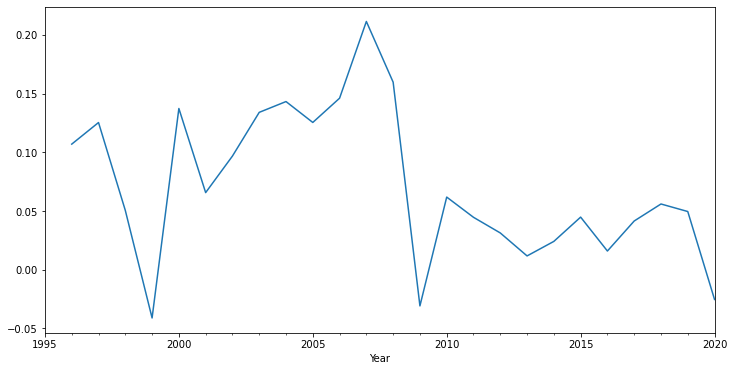

In [44]:
#Differencing data due to non stationarity - 1st difference
df['diff-1'] = diff(df['lnGDP'],k_diff=1)
df['diff-1'].plot(figsize=(12,6));

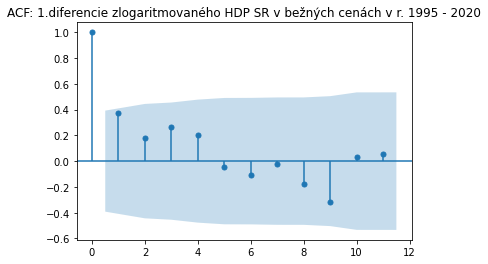

In [48]:
#ACF plot for 1st difference
title='ACF: 1.diferencie zlogaritmovaného HDP SR v bežných cenách v r. 1995 - 2020'
lags=12
plot_acf(df['diff-1'].dropna(),title=title,lags=np.arange(lags));

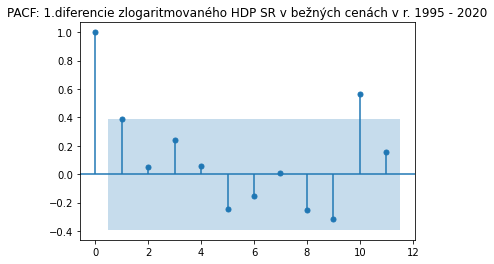

In [49]:
#PACF plot for 1st difference
title='PACF: 1.diferencie zlogaritmovaného HDP SR v bežných cenách v r. 1995 - 2020'
lags=12
plot_pacf(df['diff-1'].dropna(),title=title,lags=np.arange(lags));

In [50]:
adf_test(df['diff-1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.850652
p-value                  0.051395
# lags used              0.000000
# observations          24.000000
critical value (1%)     -3.737709
critical value (5%)     -2.992216
critical value (10%)    -2.635747
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
#Running auto_arima function which measures many different models, do the differencing on its own

stepwise_fit = auto_arima(df['lnGDP'], start_p=1, start_q=1,
                          max_p=4, max_q=4,
                          seasonal=False,
                          test='kpss',
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

KeyError: 'lnGDP'

In [55]:
# Splitting into train and test period
train = df.iloc[:20]
test = df.iloc[20:]

In [57]:
#Checking the best model after splitting

model = ARIMA(train['lnGDP'],order=(0,2,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.lnGDP   No. Observations:                   18
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  22.678
Method:                       css-mle   S.D. of innovations              0.068
Date:                Thu, 24 Feb 2022   AIC                            -39.357
Time:                        00:06:13   BIC                            -36.686
Sample:                    01-01-1997   HQIC                           -38.988
                         - 01-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0041      0.007     -0.555      0.579      -0.019       0.010
ma.L1.D2.lnGDP    -0.5724      0.239     -2.395      0.017      -1.041      -0.104
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.7470           +0.0000j            1.7470            0.0000
-----------------------------------------------------------------------------
"""

In [58]:
#Predictions calculation
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,2,1) Test predictions')

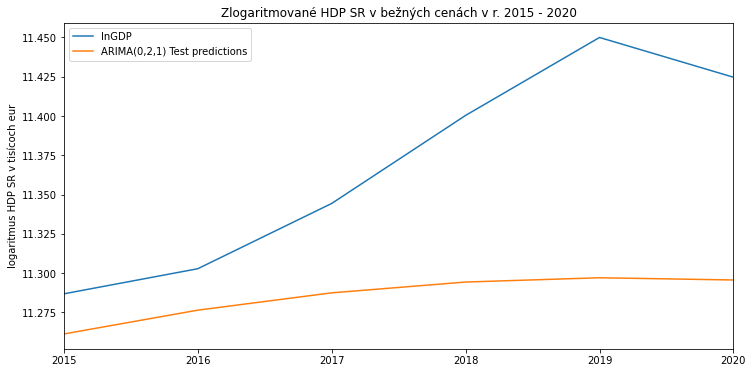

In [60]:
#Plotting predictions vs. expected data
title = 'Zlogaritmované HDP SR v bežných cenách v r. 2015 - 2020'
ylabel='logaritmus HDP SR v tisícoch eur'
xlabel='' # we don't really need a label here

ax = test['lnGDP'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [61]:
# predicted vs. expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['lnGDP'][i]}")

predicted=11.2613296 , expected=11.286872685953885
predicted=11.27648469, expected=11.302840034086953
predicted=11.2874976 , expected=11.344371893001322
predicted=11.29436833, expected=11.400391503786336
predicted=11.29709689, expected=11.44999098999581
predicted=11.29568327, expected=11.424698440289358


In [64]:
#MSE and RMSE calculation
error = mse(test['lnGDP'], predictions)
print(f'ARIMA(0,2,1) MSE Error: {error:11.10}')
error = rmse(test['lnGDP'], predictions)
print(f'ARIMA(0,2,1) RMSE Error: {error:11.10}')

ARIMA(0,2,1) MSE Error: 0.00930736231
ARIMA(0,2,1) RMSE Error: 0.09647467186


In [65]:
#Retraining the model on full dataset
model = ARIMA(df['lnGDP'],order=(0,2,1))
results = model.fit()
forecast = results.predict(len(df),len(df)+9,typ='levels').rename('ARIMA(0,2,1) Forecast')

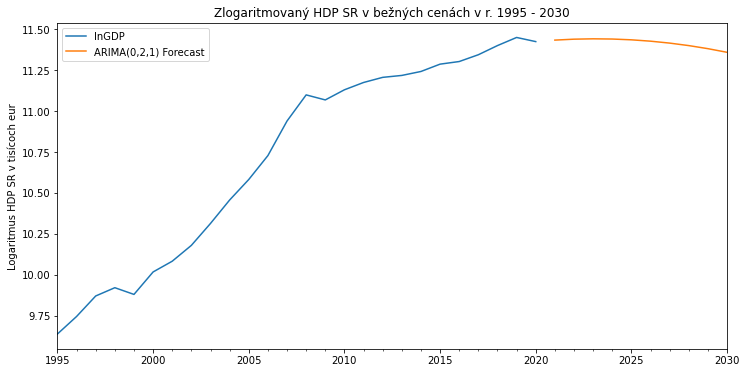

In [66]:
# Plot predictions against known values
title = 'Zlogaritmovaný HDP SR v bežných cenách v r. 1995 - 2030'
ylabel='Logaritmus HDP SR v tisícoch eur'
xlabel='' # we don't really need a label here

ax = df['lnGDP'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [67]:
forecast

2021-01-01    11.433854
2022-01-01    11.439521
2023-01-01    11.441700
2024-01-01    11.440389
2025-01-01    11.435590
2026-01-01    11.427301
2027-01-01    11.415524
2028-01-01    11.400258
2029-01-01    11.381504
2030-01-01    11.359260
Freq: AS-JAN, Name: ARIMA(0,2,1) Forecast, dtype: float64